In [5]:
import numpy as np

import tenpy
from tenpy.models.lattice import Square
from tenpy.models import CouplingMPOModel
from tenpy.networks.site import SpinHalfFermionSite, spin_half_species
from tenpy.networks.mps import MPS
from tenpy.algorithms import dmrg
from tenpy.algorithms.mps_common import DensityMatrixMixer
from timeit import default_timer as timer

import sys, os
sys.path.append('/home1/wttai/machine_learning/common_lib')
from dmrg_system import FermiHubbardSquare

In [6]:
L = 2
Lx = L
Ly = L
t = 1.0
U = 1.0
bias = 0.1
pbc = True

# Create the Fermi-Hubbard Model
model_params = {
    't': t,                 # Nearest-neighbor hopping strength
    'U': U,                 # On-site Hubbard interaction
    'Lx': Lx,
    'Ly': Ly,
    'cons_Sz': None,
    'cons_N': 'N',
    'bc_x': 'periodic' if pbc else 'open',
    'bc_y': 'periodic' if pbc else 'open',
    'bias': bias
}

dmrg_params = {
    "mixer": DensityMatrixMixer,
    "mixer_params": {
        "amplitude": 0.3,
        "decay": 2,
        "disable_after": 50
    },
    "trunc_params": {
        "chi_max": 500, #bond dimension
        "svd_min": 1*10**-10
    },
    "max_E_err": 0.0001, #energy convergence step threshold
    "max_S_err": 0.0001, #entropy convergence step threshold
    "max_sweeps": 100  #may or may not be enough to converge
}


model = FermiHubbardSquare(model_params)
H_mpo = model.calc_H_MPO()
print(f'MPO bond dimensions: {H_mpo.chi}')

MPO bond dimensions: [2, 5, 8, 8, 2]


/home1/wttai/TeNPy/tenpy/tools/params.py:232: UserWarning: unused option ['cons_Sz'] for config FermiHubbardSquare
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [3]:
# Exact Diagonalization—for sanity check
#CAUTION: this does not fix the particle fillings
import warnings
warnings.warn("Caution: This does not fix the particle fillings")
if Lx * Ly <= 8:
    test = tenpy.algorithms.exact_diag.ExactDiag(model)
    test.build_full_H_from_mpo()
    test.full_diagonalization()
    print(test.groundstate())

(-3.975386724690873, <npc.Array shape=(16,) labels=['ps']>)


In [7]:
product_state = ['empty' if n < Lx * Ly // 2 else 'full' for n in range(Lx * Ly)]
#product_state = ["up" for n in range(Lx * Ly)]

psi = MPS.from_product_state(model.lat.mps_sites(), product_state, bc=model.lat.bc_MPS, dtype=np.complex128)

engine = dmrg.TwoSiteDMRGEngine(psi, model, dmrg_params)

E0, psi = engine.run()
print(f'Ground state energy: {E0}')

Ground state energy: -3.1044225635332094


In [4]:
from dmrg_correlation_helper import compute_corr_results

correlation_types = {
    "uu": ("Nu", "Nu"),
    "ud": ("Nu", "Nd"),
    "dd": ("Nd", "Nd")
}

# Compute and store correlation results
corrs_results = {}
for label, corr_type in correlation_types.items():
    corrs_results[label] = compute_corr_results(corr_type, psi, Lx, Ly)

In [5]:
corrs_results

{'uu': array([[2.78455456e-02, 8.49330694e-08],
        [5.88278077e-05, 5.81047450e-05],
        [1.09985520e-07, 6.98480584e-08],
        [1.96092686e-05, 1.93742476e-05]]),
 'ud': array([[0.00781716, 0.00988467],
        [0.00528053, 0.00258171],
        [0.00681959, 0.00349748],
        [0.00176018, 0.00086018]]),
 'dd': array([[3.97215445e+00, 4.99666790e-05],
        [1.46835264e+00, 7.44769498e-01],
        [9.88136014e-01, 4.91996742e-01],
        [4.89450876e-01, 2.48091408e-01]])}

In [6]:
psi.correlation_function("Nu", "Nu")

array([[3.48170707e-03, 2.12332816e-08, 9.80463110e-06, 1.93742476e-05,
        2.75241169e-08, 3.49240550e-08, 9.80463110e-06, 1.93742476e-05],
       [2.12332816e-08, 3.47967827e-03, 1.93562560e-05, 9.80463750e-06,
        3.49239988e-08, 2.74686694e-08, 1.93562560e-05, 9.80463750e-06],
       [9.80463110e-06, 1.93562560e-05, 3.47967980e-03, 2.12332614e-08,
        9.80461354e-06, 1.93562947e-05, 2.74686461e-08, 3.49240034e-08],
       [1.93742476e-05, 9.80463750e-06, 2.12332614e-08, 3.48170768e-03,
        1.93742027e-05, 9.80465602e-06, 3.49240034e-08, 2.75240875e-08],
       [2.75241169e-08, 3.49239988e-08, 9.80461354e-06, 1.93742027e-05,
        3.48170011e-03, 2.12332650e-08, 9.80461354e-06, 1.93742027e-05],
       [3.49240550e-08, 2.74686694e-08, 1.93562947e-05, 9.80465602e-06,
        2.12332650e-08, 3.47968522e-03, 1.93562947e-05, 9.80465602e-06],
       [9.80463110e-06, 1.93562560e-05, 2.74686461e-08, 3.49240034e-08,
        9.80461354e-06, 1.93562947e-05, 3.47967980e-03, 2.

In [7]:
engine.sweep_stats

{'sweep': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'N_updates': [12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168],
 'E': [-28.441759799516227,
  -28.462538108291852,
  -28.462538109205475,
  -28.462538109212506,
  -28.462538109212634,
  -28.462538109212616,
  -28.462538109212645,
  -28.462538109212655,
  -28.462538109212606,
  -28.46253810921262,
  -28.46253810921262,
  -28.46253810921264,
  -28.462538109212645,
  -28.46253810921268],
 'Delta_E': [nan,
  -0.020778308775625476,
  -9.136229550676944e-10,
  -7.030820370346191e-12,
  -1.2789769243681803e-13,
  1.7763568394002505e-14,
  -2.842170943040401e-14,
  -1.0658141036401503e-14,
  4.973799150320701e-14,
  -1.4210854715202004e-14,
  0.0,
  -2.1316282072803006e-14,
  -3.552713678800501e-15,
  -3.552713678800501e-14],
 'S': [0.6953714612000205,
  0.5082200084623663,
  0.4919445951244053,
  0.4794936778162397,
  0.4711495337520923,
  0.4660261066815067,
  0.46306472738078763,
  0.4614277924369607,
  0.4605533172365

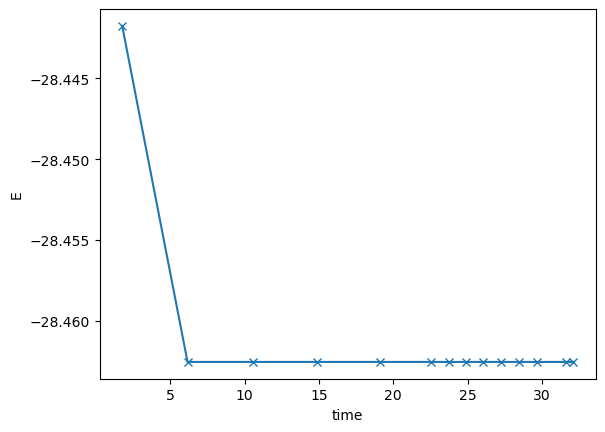

In [8]:
engine.plot_sweep_stats()

In [ ]:
# Comparison with Martin's ed result

import sys, os
sys.path.append("common_lib/test/")
from test_qwz_spin_projected_energy import test_qwz_spin_projected_energy  
test_qwz_spin_projected_energy("square_8d0", t = t, m = m, U = U) 

Using square_8d0 with qwz
Evaluating the spectrum information for U = 1.0, t = 1.0, m = 1.0.
The low energy spectrum consists of energies: [-15.92535588 -15.14535794 -14.52283518 -14.52292879 -13.91636269]
